In [140]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np

In [141]:
df0 = pd.read_csv("data/Aoutput0_cut.csv")
df1 = pd.read_csv("data/Aoutput1_cut.csv")
df2 = pd.read_csv("data/Aoutput2_cut.csv")
df3 = pd.read_csv("data/Aoutput3_anonymized.csv")
df4 = pd.read_csv("data/Boutput0_cut.csv")
df5 = pd.read_csv("data/Boutput1_cut.csv")
df6 = pd.read_csv("data/Boutput2_cut.csv")
df7 = pd.read_csv("data/hololens.csv")

dfs = [df0, df1,df2,df3,df4,df5,df6,df7]

In [142]:
for df in dfs:
    print(df.iloc[140]['caption'])

An image of a man cutting a tomato with a knife on a kitchen counter.
An image of a man chopping a tomato in a kitchen
An image of a man standing in a kitchen with a knife and a bottle
An image of a person cutting tomatoes on a cutting board.
An image of a man standing in a kitchen with a washing machine and a microwave
An image of a person standing in a kitchen with a microwave and a sink.
An image of a person standing in a kitchen with a wooden spoon and a knife on the counter.
An image of a person cutting tomatoes on a cutting board.


In [143]:
def extract_SVO(tagged_token):
    subject = ""
    verb = ""
    obj = ""

    grammar = "SOV: {<DT>?<JJ>?<N.*><V.*><IN>?<DT>?<JJ>?<N.*>}"
    cp = nltk.RegexpParser(grammar)
    tree = cp.parse(tagged_token)
    for subtree in tree.subtrees():
        if subtree.label() == "SOV":
            for leaf in subtree.leaves():
                if ('NN' in leaf[1] and subject==''):
                    subject = leaf[0]
                if 'VB' in leaf[1]:
                    verb = leaf[0]
                if ('NN' in leaf[1]):
                    obj = leaf[0]
    return subject, verb, obj

In [144]:
dfVO = pd.DataFrame()
dfVO['frame'] = df5['frame']

dfVO['candiV'] = [[] for _ in range(len(dfVO))]
dfVO['candiO'] = [[] for _ in range(len(dfVO))]

In [145]:
for df in dfs:
    captions = df["caption"]
    # tokens = nltk.word_tokenize(captions[0])
    tokens = [nltk.word_tokenize(caption) for caption in captions]
    tagged_tokens = [nltk.pos_tag(token) for token in tokens]
    # print(tagged_tokens[140])

    svos = np.array([extract_SVO(tagged_token) for tagged_token in tagged_tokens])
    # df['vos'] = [tuple(vo) for vo in svos[:,1:]]
    # df['v'] = svos[:,1]
    # df['o'] = svos[:,2]
    for i, item in enumerate(svos[:,1]):
        dfVO.at[i, 'candiV'].append(item)
    
    for i, item in enumerate(svos[:,2]):
        dfVO.at[i, 'candiO'].append(item)

In [146]:
print(dfVO.iloc[140]['candiV'])
print(dfVO.iloc[140]['candiO'])

['cutting', 'chopping', 'standing', 'cutting', 'standing', 'standing', 'standing', 'cutting']
['tomato', 'tomato', 'kitchen', 'tomatoes', 'kitchen', 'kitchen', 'kitchen', 'tomatoes']


In [147]:
ActionList = ['Stand','Kitchen','Open','Taste','Close','Tap','Cut','Chop','Break','Add','Wash','Hold','Clean','Move','Switch','Sauté','Stir','Dry',
              'Wait','Pick','Put','Read','Split','Press','Touch','Slide','Peel','Shake','Pour','Squat','Throw','Carry']

In [148]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [149]:
# 加载预训练的BERT模型和分词器
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased") .to(device)
lemmatizer = WordNetLemmatizer()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

def bert_similarity(text1, text2):
    vec1 = get_bert_embedding(text1)
    vec2 = get_bert_embedding(text2)
    return cosine_similarity(vec1, vec2)

def filter_verbs(candiV, ActionList=ActionList, threshold=0.7):
    selected_verb = ''
    selected_i = 0
    best_similarity = 0

    for i,verb_candi in enumerate(candiV):
        verb_candi = lemmatizer.lemmatize(verb_candi.lower(),pos='v')
        # print(bert_similarity(verb_candi, ActionList).squeeze())
        similarity = max(bert_similarity(verb_candi, ActionList).squeeze())
        if similarity > best_similarity:
            selected_verb = verb_candi # Keep the word most close to ActionList
            selected_i = i
            
                
    return selected_i,selected_verb

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/tokenizer_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000019DA3B25F30>, 'Connection to huggingface.co timed out. (connect timeout=10)'))"), '(Request ID: 49751d55-27c5-4270-a965-7e22a4d16c14)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json


In [150]:
# 示例
# i,verb = filter_verbs(["Dance","Chopping"])
# print(i,verb)

In [151]:
indexList = []
vlist = []

for i in range(len(dfVO)):
    index, verb = filter_verbs(dfVO.iloc[i]['candiV'])
    indexList.append(index)
    vlist.append(verb)

In [152]:
# dfVO['O'] = [dfVO['candiO'][i][indexList[i]] for i in range(len(indexList))] 
dfVO['V'] = vlist
dfVO['O'] = dfVO.apply(lambda row: lemmatizer.lemmatize(row['candiO'][indexList[row.name]].lower(),pos='n'), axis=1)

In [153]:
dfVO.iloc[140]

frame                                                  8400
candiV    [cutting, chopping, standing, cutting, standin...
candiO    [tomato, tomato, kitchen, tomatoes, kitchen, k...
V                                                       cut
O                                                    tomato
Name: 140, dtype: object

In [154]:
lab = 1
vdic = {'':0}

for v in dfVO['V'].unique():
    if v not in vdic.keys():
        vdic[v] = lab
        lab+=1

vdic

{'': 0,
 'move': 1,
 'stand': 2,
 'use': 3,
 'walk': 4,
 'open': 5,
 'reach': 6,
 'hang': 7,
 'plug': 8,
 'find': 9,
 'hold': 10,
 'clean': 11,
 'connect': 12,
 'remove': 13,
 'put': 14,
 'scatter': 15,
 'prepare': 16,
 'touch': 17,
 'throw': 18,
 'cut': 19,
 'slice': 20,
 'peel': 21,
 'chop': 22,
 'drop': 23,
 'pour': 24,
 'eat': 25,
 'sit': 26,
 'spoon': 27,
 'spread': 28,
 'add': 29,
 'toss': 30,
 'pee': 31,
 'grate': 32,
 'crack': 33,
 'whisk': 34,
 'mix': 35,
 'surround': 36,
 'take': 37,
 'press': 38,
 'cook': 39,
 'stir': 40,
 'scramble': 41,
 'wash': 42,
 'fill': 43,
 'unscrew': 44,
 'run': 45,
 'scrub': 46,
 'sharpen': 47,
 'fly': 48,
 'turn': 49}

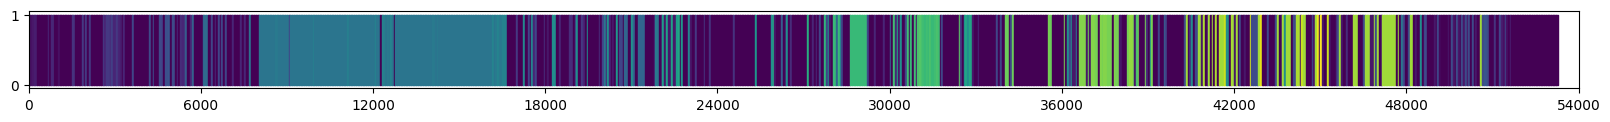

In [155]:
import matplotlib.pyplot as plt

vlist = [vdic[v] for v in dfVO['V']]

# 给定的数字列表
segments = vlist

# 获取列表中的唯一值和它们的颜色映射
unique_vals = np.unique(segments)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_vals)))
color_map = dict(zip(unique_vals, colors))

# 为进度条的每一段选择颜色
segment_colors = [color_map[val] for val in segments]

# 绘制进度条
fig, ax = plt.subplots(figsize=(20, 1))
ax.axis('on')  # 关闭坐标轴

for i, (seg, color) in enumerate(zip(segments, segment_colors)):
    ax.fill_between([i, i+1], 0, 1, color=color)

# 设置x轴的限制从0开始
ax.set_xlim(0, len(segments))

# 调整x轴的刻度标签为其30倍
locs = ax.get_xticks()  # 获取当前的x轴刻度位置
ax.set_xticks(locs)
ax.set_xticklabels([int(loc * 60) for loc in locs])

plt.show()

In [156]:
# 初始化存储结果的列表
results = []

# 初始化当前时间段的开始帧
start_frame = dfVO.iloc[0]['frame']

# 初始化当前动词和名词
current_v = dfVO.iloc[0]['V']
current_o = dfVO.iloc[0]['O']

# 遍历DataFrame中的每一行
for i, row in dfVO.iloc[1:].iterrows():
    # 检查动词和名词是否与当前段的动词和名词相同
    if row['V'] == current_v and row['O'] == current_o or row['V']=='':
        # 如果相同，继续合并
        continue
    else:
        # 否则，将当前段保存到结果中并开始新的段
        results.append({'frame': f"{start_frame}-{dfVO.iloc[i-1]['frame']}" if start_frame != dfVO.iloc[i-1]['frame'] else f"{start_frame}",
                        'V': current_v, 'O': current_o})
        start_frame = row['frame']
        current_v = row['V']
        current_o = row['O']

# 添加最后一个段
results.append({'frame': f"{start_frame}-{dfVO.iloc[-1]['frame']}" if start_frame != dfVO.iloc[-1]['frame'] else f"{start_frame}",
                'V': current_v, 'O': current_o})

# 将结果转换为DataFrame并保存为CSV
result_df = pd.DataFrame(results)
result_df.to_csv("output2.csv", index=False)

In [157]:
# 上下文语义合并